# PyBird Run Class Demo: High-Level Parameter Inference

This notebook demonstrates the **PyBird Run class**, a high-level convenience wrapper built on top of the Inference class that facilitates easy parameter minimization inference with different built-in minimizers and samplers. The also provides useful timing dignostics and other quality of life features. 


## **Import Libraries**
Setting up the required libraries for the analysis:


In [1]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import yaml

In [2]:
from getdist import loadMCSamples, plots, mcsamples, MCSamples

In [3]:
from pybird.run import Run

## **Overview: The PyBird Run Class**

The **Run class** is a convenience wrapper that:
- **Simplifies** the inference workflow by handling configuration automatically
- **Supports multiple algorithms** for both minimization and sampling
- **Manages** JAX acceleration, Taylor expansion, and other optimizations
- **Provides** a unified interface for different analysis setups

---

### **Directory Paths**

Setting up paths to data and output directories:

In [4]:
# Define directory structure
rootdir = "../"
datadir = os.path.join(rootdir, 'data', 'eftboss')
outdir = os.path.join(rootdir, 'data', 'eftboss', 'out')

### **Likelihood Configuration**

Loading and configuring the likelihood setup for BOSS CMASS NGC analysis:

In [5]:
# Configuration settings
configname = 'boss_cmass_ngc_pk_eft'  # BOSS CMASS NGC configuration

In [6]:
# Load likelihood configuration from YAML file
likelihood_config = yaml.full_load(open(os.path.join(datadir, 'config', f'{configname}.yaml'), 'r'))
# Update paths and settings
likelihood_config["data_path"] = datadir
print(yaml.dump(likelihood_config, indent=4, sort_keys=False))

data_path: ../data/eftboss
data_file: boss_dr12_2pt.h5
output: bPk
multipole: 3
with_wedge: true
wedge_type: PA-w1-w2
with_ap: true
with_survey_mask: true
sky:
    cmass_ngc:
        min:
        - 0.01
        - 0.01
        - 0.01
        max:
        - 0.3
        - 0.2
        - 0.1
write:
    save: true
    fake: false
    plot: true
    show: true
    out_path: data/eftboss/out/
    out_name: boss_pk_cmass_ngc_eft_ns
km: 0.7
kr: 0.25
nd: 0.0003
eft_basis: eftoflss
with_stoch: true
with_nnlo_counterterm: true
with_loop_prior: false
eft_prior:
    b1:
        type: lognormal
        mean:
        - 0.8
        range:
        - 0.8944
    b2:
        type: gauss
        mean:
        - 0.0
        range:
        - 2.0
    b4:
        type: gauss
        mean:
        - 0.0
        range:
        - 2.0
    b3:
        type: marg_gauss
        mean:
        - 0.0
        range:
        - 2.0
    cct:
        type: marg_gauss
        mean:
        - 0.0
        range:
        - 2.0
   

### **Run Configuration**

Setting up the inference parameters, samplers, and optimization settings:

In [7]:
# Load run configuration
run_config = yaml.full_load(open(os.path.join(datadir, 'run_config', 'run_example.yaml'), 'r'))
print(yaml.dump(run_config, indent=4, sort_keys=False))

free_cosmo_name:
- omega_cdm
- h
- ln10^{10}A_s
- n_s
fiducial_cosmo:
    omega_b: 0.02235
    omega_cdm: 0.12
    h: 0.675
    ln10^{10}A_s: 3.044
    n_s: 0.965
jax_jit: true
taylor: false
vectorize: true
measure: false
boltzmann: Symbolic
minimizers:
- minuit
- adam
- adam
- minuit
samplers:
- fisher
- emcee



---

## **Sampling Setup: Algorithms and Acceleration**

Configuring specific algorithms and optimizations for parameter inference:

### **Algorithm Selection**

Choosing minimizers and samplers for comprehensive parameter inference:

* Currently this notebook showcases all available samplers, feel free to pick the ones you are interested in to reduce the total runtime of the notebook
* Highly recommended to use a GPU here whilst sampling for extra speed!


In [8]:
minimizers = ["minuit", "adam"] #cycle to ensure we find the true minimum  
samplers = ['fisher', 'emcee', 'zeus', 'nuts', 'mclmc', 'nautilus']


### **Acceleration Settings**

Configuring JAX + Emulator acceleration and Taylor expansion for fast inference:


In [9]:
# Update run configuration for speed
run_config['free_cosmo_name'] = ['omega_cdm', 'h', 'ln10^{10}A_s']  # Vary 3 cosmological parameters

# Acceleration settings
run_config['boltzmann'] = 'Symbolic'  # Use differentiable Boltzmann solver
run_config['taylor'] = True  # Enable Taylor expansion for speedup
likelihood_config['with_emu'] = True  # Enable emulation for additional speedup

print("**Acceleration Features:**")
print(f"Boltzmann: {run_config['boltzmann']}")
print(f"Taylor Expansion: {run_config['taylor']}")
print(f"Emulation: {likelihood_config['with_emu']}")
print(f"Free Parameters: {run_config['free_cosmo_name']}")

**Acceleration Features:**
Boltzmann: Symbolic
Taylor Expansion: True
Emulation: True
Free Parameters: ['omega_cdm', 'h', 'ln10^{10}A_s']


### **Initialize Run Class**

Creating the Run instance with our configuration:


In [10]:
# Initialize the Run class
print("**Initializing PyBird Run Class...**")
R = Run(run_config, likelihood_config, outdir, verbose=True)

**Initializing PyBird Run Class...**
free_cosmo_name: ['omega_cdm', 'h', 'ln10^{10}A_s']
fiducial_cosmo: {'omega_b': 0.02235, 'omega_cdm': 0.12, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
cosmo_prior: False
ext_probe: False
ext_loglkl: None
measure: False
taylor_measure: False
debiasing: False
hessian_type: None
vectorize: True
taylor: True
jax_jit: True
order: 3
boltzmann: Symbolic
'vectorize' or 'taylor' is True, setting 'jax_jit' to True
jax: on


ERROR:2025-07-28 21:07:47,761:jax._src.xla_bridge:647: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/cluster/project/refregier/areeves/pybird_clean/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 645, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/cluster/project/refregier/areeves/pybird_clean/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 103, in initialize
    triton.register_compilation_handler(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'jax._src.lib.triton' has no attribute 'register_compilation_handler'


reading data file: ../data/eftboss/boss_dr12_2pt.h5
-----------------------
sky: cmass_ngc
output: bPk
wedge (rotation of multipole): PA-w1-w2 | read wedge instead of multipole in the following
multipole: 3
min bound (per multipole): [0.01, 0.01, 0.01]
max bound (per multipole): [0.3, 0.2, 0.1]
coordinate (AP) distortion: on
survey mask: on
-----------------------
cmass_ngc: Hartlap factor correction on precision matrix estimated from 2048 mocks for 53 bins
-----------------------
get_maxlkl : False
with_boss_correlated_skies_prior : False
with_rs_marg : False
drop_logdet : False
cache : False
-----------------------


---

## **Parameter Inference: Minimization & Sampling**

Now we'll run the complete inference pipeline:

* Note when using all of these samplers sequnetially this takes ~10 minutes on a GPU and ~30 minutes on a CPU 
* Just looking at a given sampler is as simple as removing the others from the list of "samplers" 


In [12]:
print("**Starting Parameter Inference Pipeline...**")
print("\n" + "="*60)

# Run the complete inference pipeline
results = R.run(
    minimizers=minimizers,
    samplers=samplers,
    sample_fake=False,
    output=True,
    save_to_file=False,
    hash_file=configname,
    verbose=True
)

print("\n" + "="*60)


**Starting Parameter Inference Pipeline...**

----- minimisation with minuit -----
starting from previously found best-fit
minimisation starts...
minimisation done in 0.123 sec.
min chi2: 47.453, ndata: 53, dof: 39, p-value: 0.166
bestfit ['omega_cdm', 'h', 'ln10^{10}A_s', 'b2', 'b4']: [0.129 0.697 2.81  2.179 0.751]
----- minimisation with adam -----
starting from previously found best-fit
minimisation starts...
Stopping at step 195 due to chi2 plateauing.
minimisation done in 10.377 sec.
min chi2: 47.454, ndata: 53, dof: 39, p-value: 0.166
bestfit ['omega_cdm', 'h', 'ln10^{10}A_s', 'b2', 'b4']: [0.129 0.697 2.811 2.177 0.744]
----- sampling with fisher -----
starting from previously found best-fit
sampling starts...


/cluster/work/refregier/alexree/local_packages/pybird_emu/pybird/inference.py:191: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = multivariate_normal(initial_pos, self.C_fisher, size=size)


sampling done in 20.325 sec.
----- sampling with emcee -----
starting from previously found best-fit
emcee: vectorized
sampling starts...
Fisher matrix found: drawing initial conditions from multivariate normal


/cluster/work/refregier/alexree/local_packages/pybird_emu/pybird/inference.py:203: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  self.pos = multivariate_normal(initial_pos, self.C_fisher, size=n_walkers)
100%|██████████| 20000/20000 [01:34<00:00, 211.76it/s]


autocorr time:  [ 75.  72. 104. 108. 119.]
sampling done in 96.357 sec.
----- sampling with zeus -----


/cluster/work/refregier/alexree/local_packages/pybird_emu/pybird/inference.py:228: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  self.pos = multivariate_normal(initial_pos, self.C_fisher, size=n_walkers)
Initialising ensemble of 20 walkers...


starting from previously found best-fit
zeus: vectorized
sampling starts...
Fisher matrix found: drawing initial conditions from multivariate normal


Sampling progress : 100%|██████████| 20000/20000 [08:03<00:00, 41.35it/s]


sampling done in 485.318 sec.
----- sampling with nuts -----
starting from previously found best-fit
sampling starts...
warmup done in 42 sec.
avg accept rate: 0.81, frac divergent: 0.000
sampling done in 92 sec.
sampling done in 135.460 sec.
----- sampling with mclmc -----
starting from previously found best-fit
sampling starts...
MCLMC: Running adaptation for 50000 steps...
MCLMC: Adaptation result has 3 elements
MCLMC: Adaptation successful...
MCLMC: Running sampling for 125000 steps...
MCLMC: Sampling completed...
sampling done in 194.450 sec.
----- sampling with nautilus -----
starting from previously found best-fit
sampling starts...
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 37     | 1        | 4        | 89000    | N/A    | 17213 | -46.01   
sampling done in 678.809 sec.



---

## **Results Analysis & Visualization**

Analyzing and visualizing the inference results:


### **Prepare GetDist Samples**

Converting PyBird results to GetDist format for analysis:


In [13]:
# Convert results to GetDist MCSamples format
samples = {}
for sampler in samplers:
    if sampler in results:
        samples[sampler] = MCSamples(
            samples=results[sampler]['samples'],
            names=results[sampler]['free parameters'],
            labels=results[sampler]['free parameters']
        )

print("**Sample Statistics:**")
for sampler, sample in samples.items():
    print(f"   {sampler}: {len(sample.samples)} samples")

print("\nGetDist samples prepared successfully!")

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
**Sample Statistics:**
   fisher: 5000 samples
   emcee: 3740 samples
   zeus: 3760 samples
   nuts: 2500 samples
   mclmc: 125000 samples
   nautilus: 2500 samples

GetDist samples prepared successfully!


### **Triangle Plot: Posterior Comparison**

Creating a comprehensive triangle plot comparing all sampling methods:


**Creating Triangle Plot...**


/scratch/tmp.38645934.areeves/ipykernel_987722/627178468.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


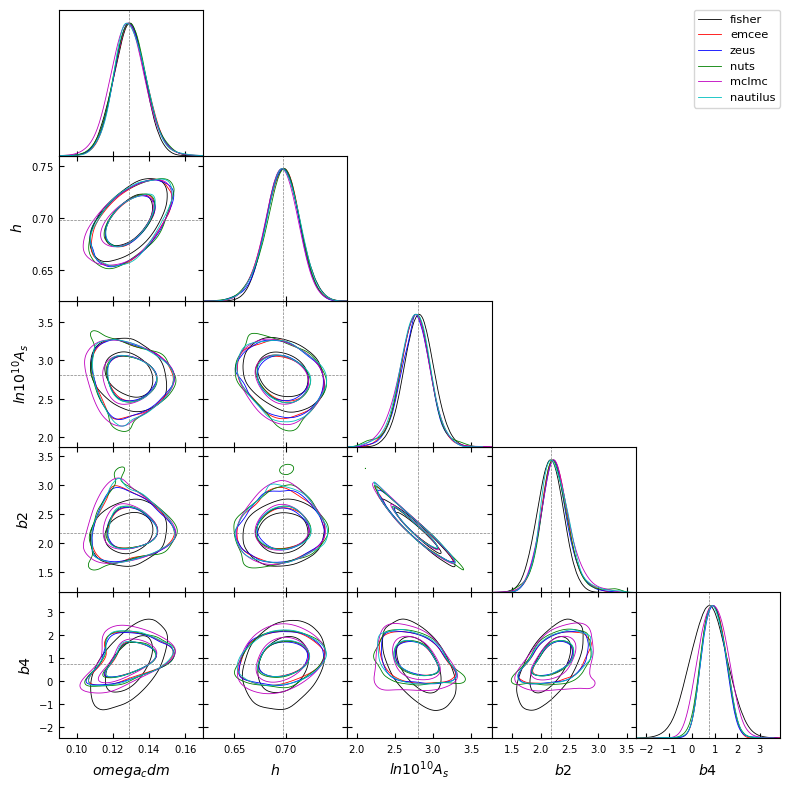


Triangle plot created successfully!


In [15]:
# Create triangle plot comparing all samplers
%matplotlib inline 
print("**Creating Triangle Plot...**")

g = plots.get_subplot_plotter(width_inch=8)
g.triangle_plot(
    [s for s in samples.values()],
    results['mclmc']['free parameters'],
    filled=False,
    markers=results['minuit']['bestfit'],
    legend_labels=[l for l in samples.keys()],
    legend_loc="upper right",
    
)

plt.tight_layout()
plt.show()

print("\nTriangle plot created successfully!")
